In [259]:
# read modules 
from bs4 import BeautifulSoup
import requests, lxml, os, json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import date 

## 1. Google scholar 

In [268]:
## Take the names from google scholar 
import requests, lxml, os

headers = {
    'User-agent':
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.19582"
}

proxies = {
  'http': os.getenv('HTTP_PROXY')
}

html = requests.get('https://scholar.google.com/citations?view_op=view_org&hl=en&org=14840063360674909190&before_author=Ez67_yABAAAJ&astart=0', headers=headers, proxies=proxies).text
soup = BeautifulSoup(html, 'lxml')

names = []; links = []; focus = []

for result in soup.select('.gs_ai_chpr'):
    name = result.select_one('.gs_ai_name a').text
    link = result.select_one('.gs_ai_name a')['href']

    # https://stackoverflow.com/a/6633693/15164646
    _id = link
    id_identifer = 'user='
    before_keyword, keyword, after_keyword = _id.partition(id_identifer)
    author_id = after_keyword
    affiliations = result.select_one('.gs_ai_aff').text
    email = result.select_one('.gs_ai_eml').text

    try:
        interests = result.select_one('.gs_ai_one_int').text
    except:
        interests = None

    cited_by = result.select_one('.gs_ai_cby').text.split(' ')[2]
    names.append(name)
    links.append(f'https://scholar.google.com{link}')
    focus.append(interests)
    # print(f'{name}\nhttps://scholar.google.com{link}\n{interests}\n{cited_by}\n{author_id}')

data = pd.DataFrame([names, links, focus]).T
data.columns = ['Author', 'Link', 'Focus']
## get the data for each author 
citations_al = []; citations_sinc = []; h_index_al = []; h_index_sinc= []; i10_index_al = []; i10_index_sinc = []
for link in data['Link']:
    html = requests.get(link, headers=headers).text
    soup = BeautifulSoup(html, 'lxml')
    # print(f'Collecting data for: {name}')
    for cited_by_public_access in soup.select('.gsc_rsb'):
        citations_all = cited_by_public_access.select_one('tr:nth-child(1) .gsc_rsb_sc1+ .gsc_rsb_std').text
        citations_since = cited_by_public_access.select_one('tr:nth-child(1) .gsc_rsb_std+ .gsc_rsb_std').text
        h_index_all = cited_by_public_access.select_one('tr:nth-child(2) .gsc_rsb_sc1+ .gsc_rsb_std').text
        h_index_since = cited_by_public_access.select_one('tr:nth-child(2) .gsc_rsb_std+ .gsc_rsb_std').text
        i10_index_all = cited_by_public_access.select_one('tr~ tr+ tr .gsc_rsb_sc1+ .gsc_rsb_std').text
        i10_index_since = cited_by_public_access.select_one('tr~ tr+ tr .gsc_rsb_std+ .gsc_rsb_std').text
        ## append the output into a list 
        citations_al.append(citations_all)
        citations_sinc.append(citations_since)
        h_index_al.append(h_index_all)
        h_index_sinc.append(h_index_since)
        i10_index_al.append(i10_index_all)
        i10_index_sinc.append(i10_index_since)
    # print(f'{citations_all}\n{citations_since2016}\n{h_index_all}\n{h_index_2016}\n{i10_index_all}\n{i10_index_2016}')
extra_data = pd.DataFrame([citations_al, citations_sinc, h_index_al, h_index_sinc, i10_index_al, i10_index_sinc]).T
extra_data.columns = ['Total citations', 'Citation l 5 yrs', 'Total H-index', "H-index l 5 yrs", "Total i10-index", 'i10-index l 5 yrs']
output = pd.concat([data, extra_data], axis =1).drop('Link', axis =1)
for i in output.columns[2:]:
    output[i] = pd.to_numeric(output[i])
    
output.to_excel('Output/Data.xlsx', index = False)    
output.style.background_gradient(cmap='Spectral', subset=output.columns[2:])

,Author,Focus,Total citations,Citation l 5 yrs,Total H-index,H-index l 5 yrs,Total i10-index,i10-index l 5 yrs
0,Ana Beatriz Lopes de Sousa Jabbour,Sustainable Supply Chain Management,9581,8428,49,43,107,100
1,Christophe Estay,Entrepreneuriat,722,610,13,9,14,9
2,Tibor MANDJAK,business marketing,694,265,13,9,19,9
3,Olivier Lamotte,International Trade,588,415,13,11,14,12
4,Sylvaine Castellano,Management,548,470,12,12,17,17
5,BELAID Samy,Marketing,486,320,7,5,3,2
6,Octavio Escobar,FDI,443,387,8,8,8,7
7,Olivier Faury,Arctic,412,401,11,11,13,13
8,Sébastien Bourdin,Economic geography,402,361,12,12,17,15
9,Alexandre Renaud,Systèmes d'information,298,261,7,6,5,4


In [283]:
from adjustText import adjust_text
plt.rcParams['axes.facecolor'] = '#f4f9fa'

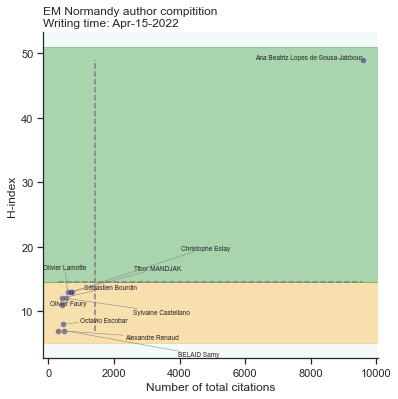

In [288]:
# sns.set_theme(style="ticks", palette = 'pastel')
fig = plt.figure(figsize = (6,6))
sns.scatterplot(x = 'Total citations', y = "Total H-index", data = output, alpha = .5, color = 'midnightblue', legend = False)
## add the decision boundaries lines 
plt.vlines(x = output['Total citations'].mean(), ymin = output['Total H-index'].min() , ymax = output['Total H-index'].max(), color = 'grey', linestyle = 'dashed')
plt.hlines(y = output['Total H-index'].mean(), xmin = output['Total citations'].min() , xmax = output['Total citations'].max(), color = 'grey', linestyle = 'dashed')
## add the decisipon boudnaries colors 
plt.axhspan(ymin = output['Total H-index'].min() - 2, ymax = output['Total H-index'].mean() , alpha = .3, zorder = -1, color = 'orange')
plt.axhspan(ymin = output['Total H-index'].mean(), ymax = output['Total H-index'].max() + 2, alpha = .3, zorder = -1, color = 'green')

# plt.axvspan(xmin = output['Total citations'].mean(), xmax = output['Total citations'].max() + 150,  alpha = .3, zorder = -1, color = 'green')
# plt.axvspan(xmin = output['Total citations'].mean(), xmax = output['Total citations'].max() + 150,  alpha = .3, zorder = -1, color = 'green')

## plot the names of the authors 
# # add cities names 
texts = []
for y, x, label in zip(output['Total H-index'], output['Total citations'], output.Author):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

adjust_text(texts, force_points=0.3, force_text=0.3,
            expand_points=(1, 1), expand_text=(1, 3.5),
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

## add texts s
plt.title(f'EM Normandy author compitition\nWriting time: {date.today().strftime("%b-%d-%Y")}', loc = 'left')
plt.xlabel('Number of total citations'); plt.ylabel('H-index')
sns.despine()
plt.show()

In [223]:
import requests, re, json
from parsel import Selector

def scrape_all_authors_from_university(label: str, university_name: str) -> list[dict[str]]:

    params = {
        "view_op": "search_authors",                       # author results
        "mauthors": f'label:{label} "{university_name}"',  # search query
        "hl": "en",                                        # language
        "astart": 0                                        # page number
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.87 Safari/537.36",
    }

    profile_results = []

    profiles_is_present = True
    while profiles_is_present:

        html = requests.get("https://scholar.google.com/citations", params=params, headers=headers, timeout=30)
        select = Selector(html.text)

        print(f"extracting authors at page #{params['astart']}.")

        for profile in select.css(".gs_ai_chpr"):
            name = profile.css(".gs_ai_name a::text").get()
            link = f'https://scholar.google.com{profile.css(".gs_ai_name a::attr(href)").get()}'
            affiliations = profile.css(".gs_ai_aff").xpath('normalize-space()').get()
            email = profile.css(".gs_ai_eml::text").get()
            cited_by = re.search(r"\d+", profile.xpath('//div[@class="gs_ai_cby"]').get()).group()  # Cited by 17143 -> 17143
            interests = profile.css(".gs_ai_one_int::text").getall()

            profile_results.append({
                "profile_name": name,
                "profile_link": link,
                "profile_affiliations": affiliations,
                "profile_email": email,
                "profile_city_by_count": cited_by,
                "profile_interests": interests
            })

        # if next page token is present -> update next page token and increment 10 to get the next page
        if select.css("button.gs_btnPR::attr(onclick)").get():
            # https://regex101.com/r/e0mq0C/1
            params["after_author"] = re.search(r"after_author\\x3d(.*)\\x26", select.css("button.gs_btnPR::attr(onclick)").get()).group(1)  # -> XB0HAMS9__8J
            params["astart"] += 10
        else:
            profiles_is_present = False

    return profile_results


print(json.dumps(scrape_all_authors_from_university(label = 'social metabolism', university_name="EM Normandie"), indent=2))

extracting authors at page #0.
[]


## 2. Researchgate 

In [ ]:
## Take the names on authors on researchgate 

